# 10 minute ANTsPy tutorial

ANTsPy is a Python wrapper for the ANTs neuroimage processing library, along with other pythonic tools that make it easy and fun to work with brain images directly in Python.

This tutorial is available at https://github.com/ANTsX/ANTsPy/tree/master/tutorials.

First, install ANTsPy. It can be installed from source (takes 30-60min) with the following code:

```
git clone https://github.com/ANTsX/ANTsPy.git
cd ANTsPy
python setup.py install
```

It can also be installed very quickly from pre-made wheels (latest release only available for Mac, but a previous release is available for Linux which should be OK): https://github.com/ANTsX/ANTsPy/releases . Download the .whl file then run the following:
```
pip install /path/to/file.whl
```

In [ ]:
# Alternative installation working for Linux
```
conda create -n antspy python=3.8
conda activate antspy
pip install antspyx
```

In [1]:
import ants
import numpy as np

# Image IO

Reading and writing images is easy. ANTsPy has some included data which we will use.

In [2]:
fname1 = ants.get_ants_data('r16')
fname2 = ants.get_ants_data('r64')
print(fname1)

/Users/fernandes/.antspy/r16slice.jpg


In [3]:
img1 = ants.image_read(fname1)
img2 = ants.image_read(fname2)
print(img1)

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]



You can read also convert numpy arrays to ANTsImage types.. Here's an example of an fMRI image (an image with "components")

In [4]:
arr_4d = np.random.randn(70,70,70,10).astype('float32')
img_fmri = ants.from_numpy(arr_4d, has_components=True)
print(img_fmri)

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 10
	 Dimensions : (70, 70, 70)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]



Once you have an ANTsImage type, it basically acts as a numpy array:

In [5]:
# clone
img = ants.image_read(fname1)
img2 = img.clone()

# convert to numpy
img_arr = img.numpy()

# create another image with same properties but different data
img2 = img.new_image_like(img_arr*2)

# save to file
# img.to_file(...)

# many useful things:
img.median()
img.std()
img.argmin()
img.argmax()
img.flatten()
img.nonzero()
img.unique()

# do any operations directly on ANTsImage types
img3 = img2 - img
img3 = img2 > img
img3 = img2 / img
img3 = img2 == img


# change any physical properties
img4 = img.clone()
print(img4.spacing)
img4.set_spacing((1,1))
print(img4.spacing)

# test if two images are allclose in values
issame = ants.allclose(img,img2)

# test if two images have same physical space
issame_phys = ants.image_physical_space_consistency(img,img2)


(1.0, 1.0)
(1.0, 1.0)


/Users/fernandes/anaconda3/envs/antspy/lib/python3.9/site-packages/ants/core/ants_image.py:476: RuntimeWarning:

invalid value encountered in true_divide



## Segmentation

This module includes Atropos segmentation, Joint Label Fusion, cortical thickness estimation, and prior-based segmentation.

Atropos segmentation:

dict_keys(['segmentation', 'probabilityimages'])


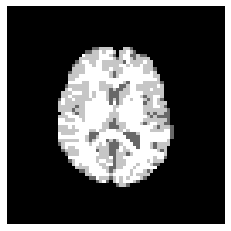

In [7]:
img = ants.image_read(ants.get_ants_data('r16'))
img = ants.resample_image(img, (64,64), 1, 0)
mask = ants.get_mask(img)
img_seg = ants.atropos(a=img, m='[0.2,1x1]', c='[2,0]', 
                       i='kmeans[3]', x=mask)
print(img_seg.keys())
ants.plot(img_seg['segmentation'])

Cortical thickness:

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]



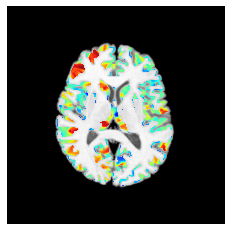

In [9]:
img = ants.image_read( ants.get_ants_data('r16') ,2)
mask = ants.get_mask( img ).threshold_image( 1, 2 )
segs=ants.atropos( a = img, m = '[0.2,1x1]', c = '[2,0]',  i = 'kmeans[3]', x = mask )
thickimg = ants.kelly_kapowski(s=segs['segmentation'], g=segs['probabilityimages'][1],
                            w=segs['probabilityimages'][2], its=45, 
                            r=0.5, m=1)
print(thickimg)
img.plot(overlay=thickimg, overlay_cmap='jet')

## Registration

This module includes the main ANTs registration interface, from which all registration algorithms can be run - along with various functions for evaluating registration algorithms or resampling/reorienting images or applying specific transformations to images.

SyN registration:

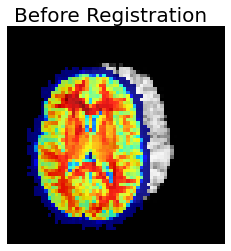

{'warpedmovout': ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64)
	 Spacing    : (4.0476, 4.0476)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, 'warpedfixout': ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64)
	 Spacing    : (4.0476, 4.0476)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, 'fwdtransforms': ['/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmphpefo2fc1Warp.nii.gz', '/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmphpefo2fc0GenericAffine.mat'], 'invtransforms': ['/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmphpefo2fc0GenericAffine.mat', '/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmphpefo2fc1InverseWarp.nii.gz']}


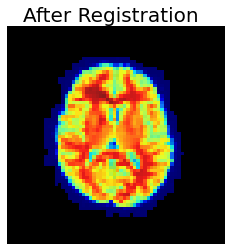

In [10]:
fixed = ants.image_read( ants.get_ants_data('r16') ).resample_image((64,64),1,0)
moving = ants.image_read( ants.get_ants_data('r64') ).resample_image((64,64),1,0)
fixed.plot(overlay=moving, title='Before Registration')
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='SyN' )
print(mytx)
warped_moving = mytx['warpedmovout']
fixed.plot(overlay=warped_moving,
           title='After Registration')

In [14]:
mytx

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (64, 64)
 	 Spacing    : (4.0476, 4.0476)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (64, 64)
 	 Spacing    : (4.0476, 4.0476)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmphpefo2fc1Warp.nii.gz',
  '/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmphpefo2fc0GenericAffine.mat'],
 'invtransforms': ['/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmphpefo2fc0GenericAffine.mat',
  '/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmphpefo2fc1InverseWarp.nii.gz']}

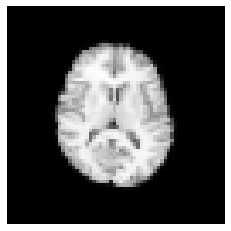

In [13]:
mytx['warpedmovout'].plot()

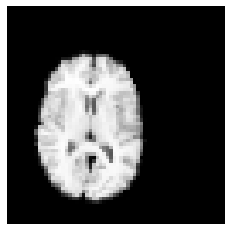

In [15]:
mytx['warpedfixout'].plot()

You can also use the transforms output from registration and apply them directly to the image:

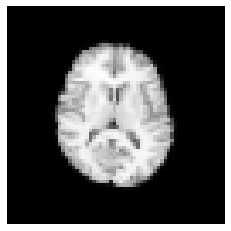

In [16]:
mywarpedimage = ants.apply_transforms(fixed=fixed, moving=moving,
                                      transformlist=mytx['fwdtransforms'])

mywarpedimage.plot()

## Other utilities

N3 and N4 bias correction:

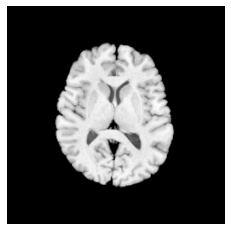

In [17]:
image = ants.image_read( ants.get_ants_data('r16') )
image_n4 = ants.n4_bias_field_correction(image)
ants.plot( image_n4 )

Move to & from nibabel images with `ants.to_nibabel()` and `ants.from_nibabel()`